<a href="https://colab.research.google.com/github/hrithikwel8/Rossmann_Sales_Prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/Rossmann Sales Prediction/'
store_data_df = pd.read_csv(path + 'Rossmann Stores Data.csv')
store_df = pd.read_csv(path + 'store.csv')

#1. EDA

In [4]:
store_data_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [7]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [8]:
missing_values= store_df.isnull()

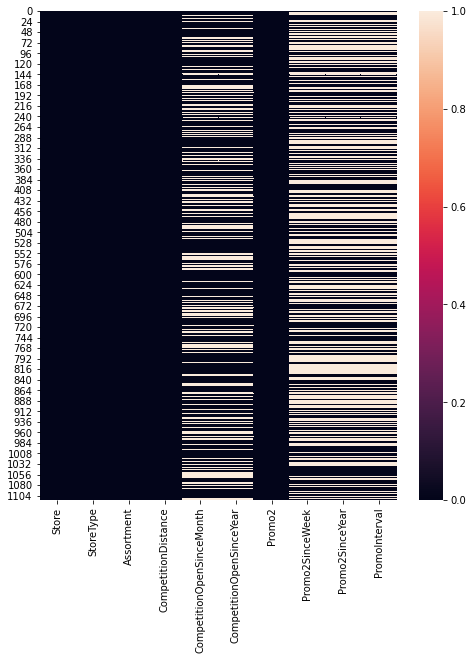

In [9]:
#Heatmap of missing values in the store_df 
plt.figure(figsize=(8,9))
sns.heatmap(missing_values)

In [10]:
store_df['CompetitionOpenSinceMonth'].fillna(0,inplace=True)

In [11]:
store_df['CompetitionOpenSinceYear'].fillna(0,inplace=True)

In [12]:
# this features shows NaN values for all the stores which doesnt run promos and hence we substitute the value of Nan to 0
store_df['Promo2SinceWeek'].fillna(0,inplace=True)
store_df['Promo2SinceYear'].fillna(0,inplace=True)

In [13]:
store_df['CompetitionDistance'].fillna(0,inplace=True)

In [14]:
store_df['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [15]:
# Converting Qualitative Values to Quantitative
def Promo_interval1(row):
  if (row['PromoInterval'] == 'Jan,Apr,Jul,Oct'):
    val = 1
  else:
    val = 0
  return val
def Promo_interval2(row):
  if (row['PromoInterval'] == 'Feb,May,Aug,Nov'):
    val = 1
  else:
    val = 0
  return val
def Promo_interval3(row):
  if (row['PromoInterval'] == 'Mar,Jun,Sept,Dec'):
    val = 1
  else:
    val = 0
  return val
def Store_type1(row):
  if (row['StoreType'] == 'a'):
    val = 1
  else:
    val = 0
  return val
def Store_type2(row):
  if (row['StoreType'] == 'b'):
    val = 1
  else:
    val = 0
  return val
def Store_type3(row):
  if (row['StoreType'] == 'c'):
    val = 1
  else:
    val = 0
  return val
def Store_type4(row):
  if (row['StoreType'] == 'd'):
    val = 1
  else:
    val = 0
  return val
def Assortment_level1(row):
  if (row['Assortment'] == 'a'):
    val = 1
  else:
    val = 0
  return val
def Assortment_level2(row):
  if (row['Assortment'] == 'b'):
    val = 1
  else:
    val = 0
  return val
def Assortment_level3(row):
  if (row['Assortment'] == 'c'):
    val = 1
  else:
    val = 0
  return val

In [16]:
store_df['PromoInterval1'] = store_df.apply(Promo_interval1,axis=1)
store_df['PromoInterval2'] = store_df.apply(Promo_interval2,axis=1)
store_df['PromoInterval3'] = store_df.apply(Promo_interval3,axis=1)
store_df['StoreType1'] = store_df.apply(Store_type1,axis=1)
store_df['StoreType2'] = store_df.apply(Store_type2,axis=1)
store_df['StoreType3'] = store_df.apply(Store_type3,axis=1)
store_df['StoreType4'] = store_df.apply(Store_type4,axis=1)
store_df['AssortmentLeve1'] = store_df.apply(Assortment_level1,axis=1)
store_df['AssortmentLeve2'] = store_df.apply(Assortment_level2,axis=1)
store_df['AssortmentLeve3'] = store_df.apply(Assortment_level3,axis=1)

In [17]:
store_df.drop(labels='PromoInterval',axis=1,inplace=True)
store_df.drop(labels='StoreType',axis=1,inplace=True)
store_df.drop(labels='Assortment',axis=1,inplace=True)

In [18]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   CompetitionDistance        1115 non-null   float64
 2   CompetitionOpenSinceMonth  1115 non-null   float64
 3   CompetitionOpenSinceYear   1115 non-null   float64
 4   Promo2                     1115 non-null   int64  
 5   Promo2SinceWeek            1115 non-null   float64
 6   Promo2SinceYear            1115 non-null   float64
 7   PromoInterval1             1115 non-null   int64  
 8   PromoInterval2             1115 non-null   int64  
 9   PromoInterval3             1115 non-null   int64  
 10  StoreType1                 1115 non-null   int64  
 11  StoreType2                 1115 non-null   int64  
 12  StoreType3                 1115 non-null   int64  
 13  StoreType4                 1115 non-null   int64

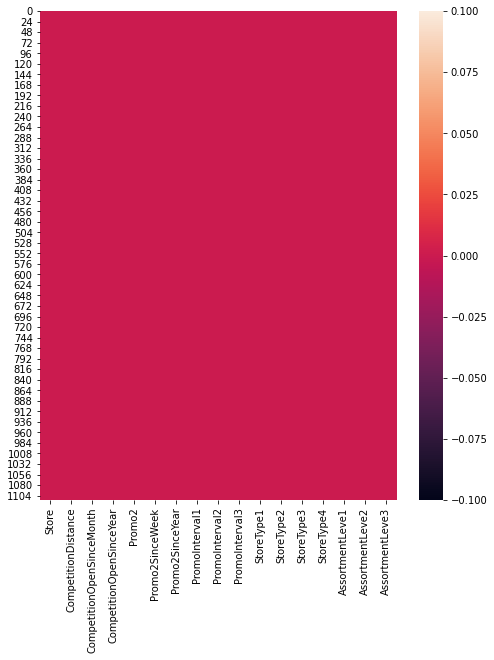

In [19]:
# The heatmap after filling all the NaN values
final_na_df= store_df.isnull()
plt.figure(figsize=(8,9))
sns.heatmap(final_na_df)

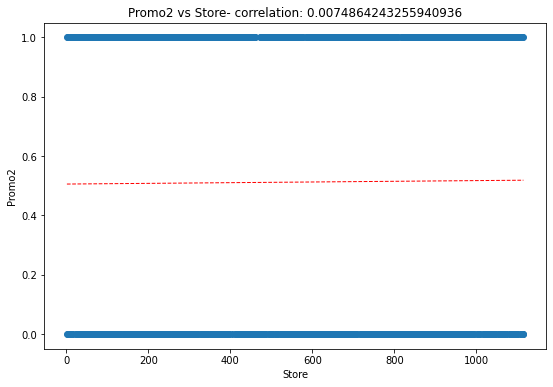

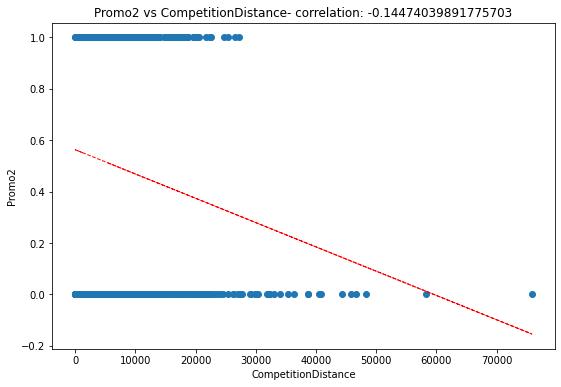

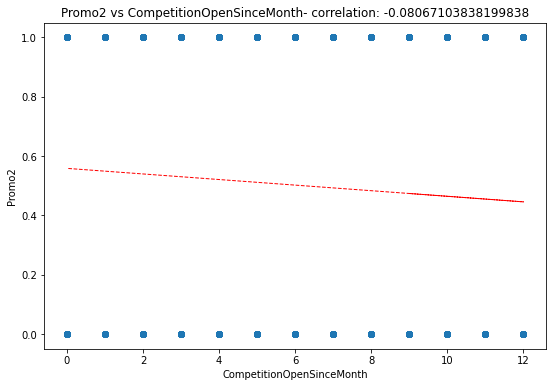

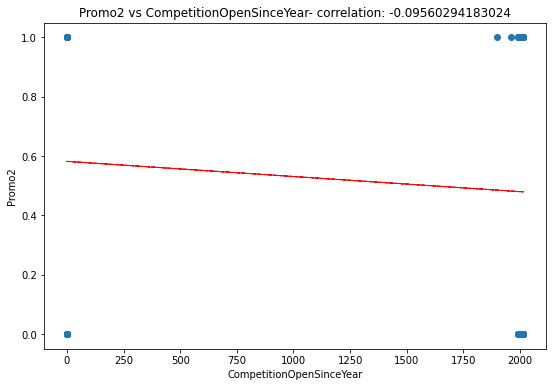

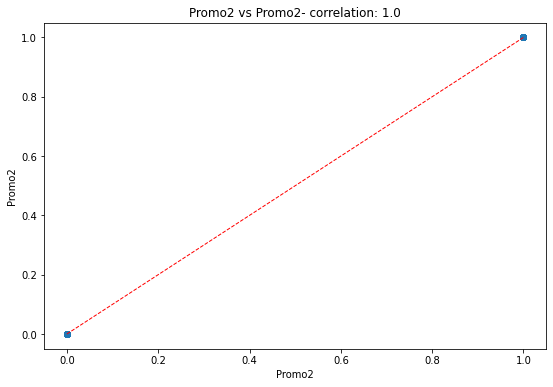

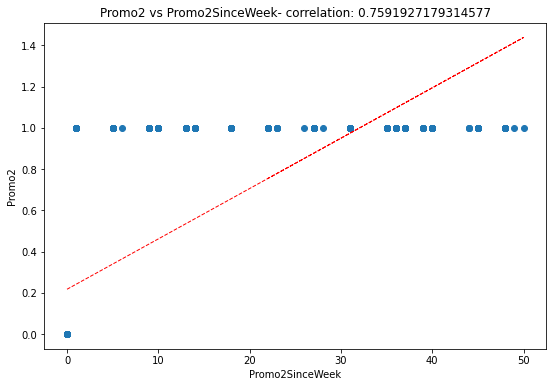

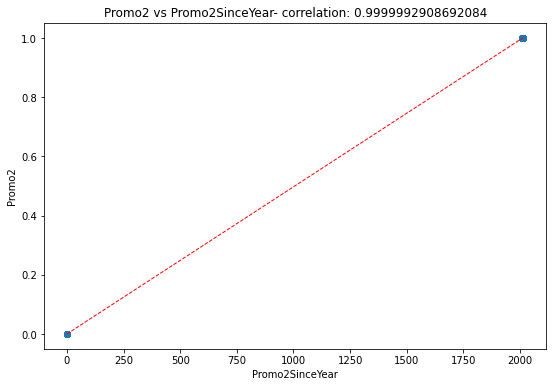

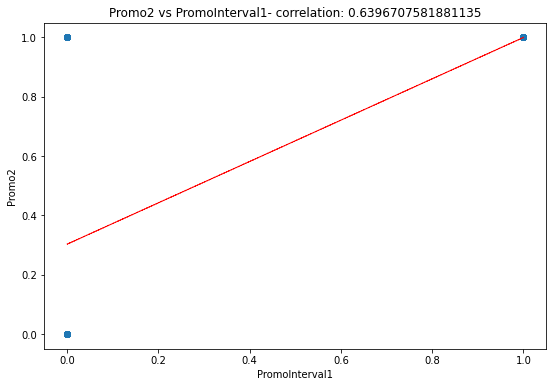

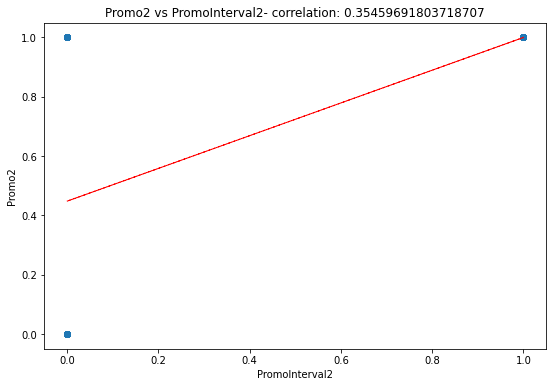

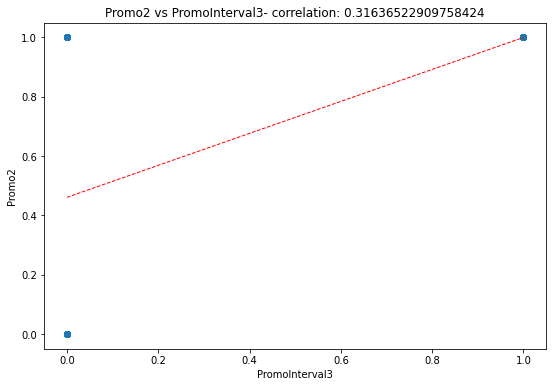

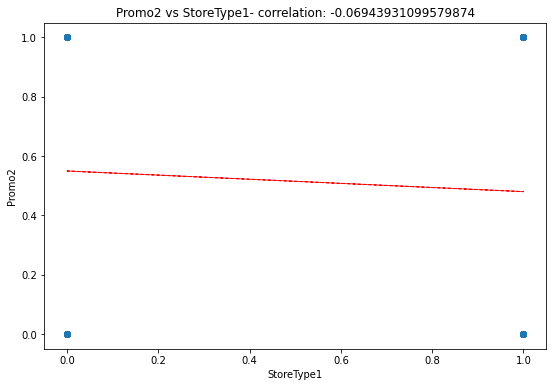

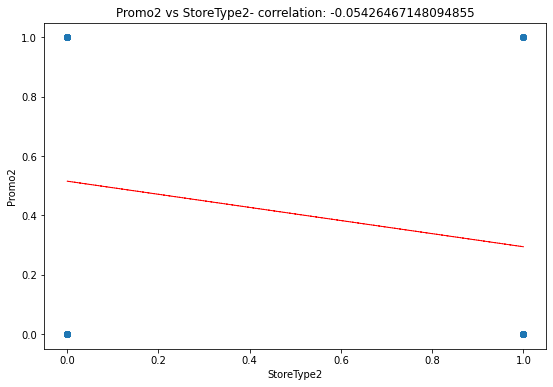

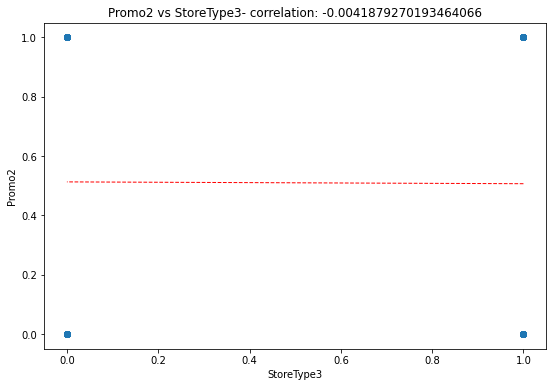

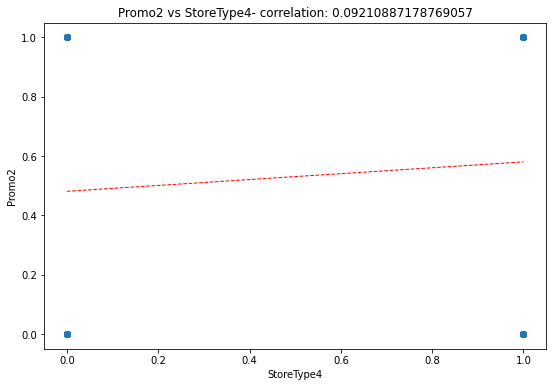

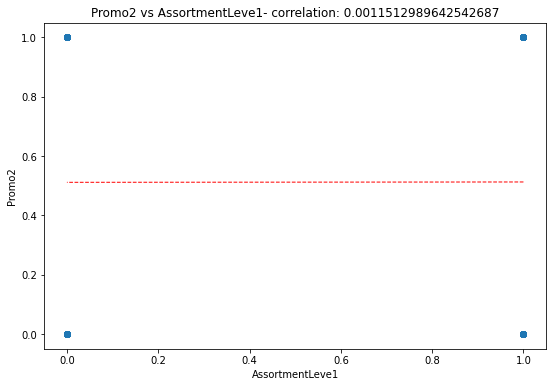

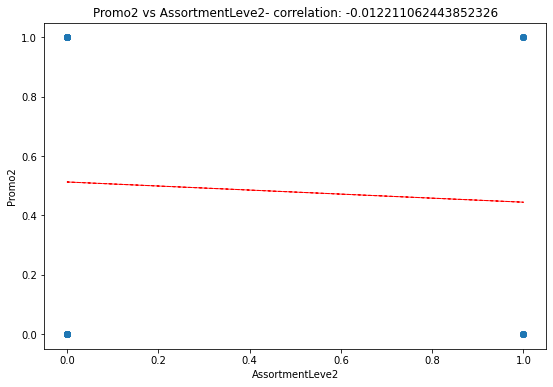

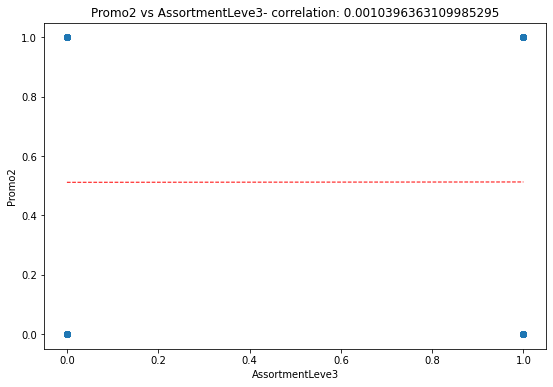

In [20]:
for col in store_df:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = store_df[col]
    label = store_df['Promo2']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Promo2')
    ax.set_title('Promo2 vs ' + col + '- correlation: ' + str(correlation))
    z = np.polyfit(store_df[col], store_df['Promo2'], 1)
    y_hat = np.poly1d(z)(store_df[col])

    plt.plot(store_df[col], y_hat, "r--", lw=1)

plt.show()

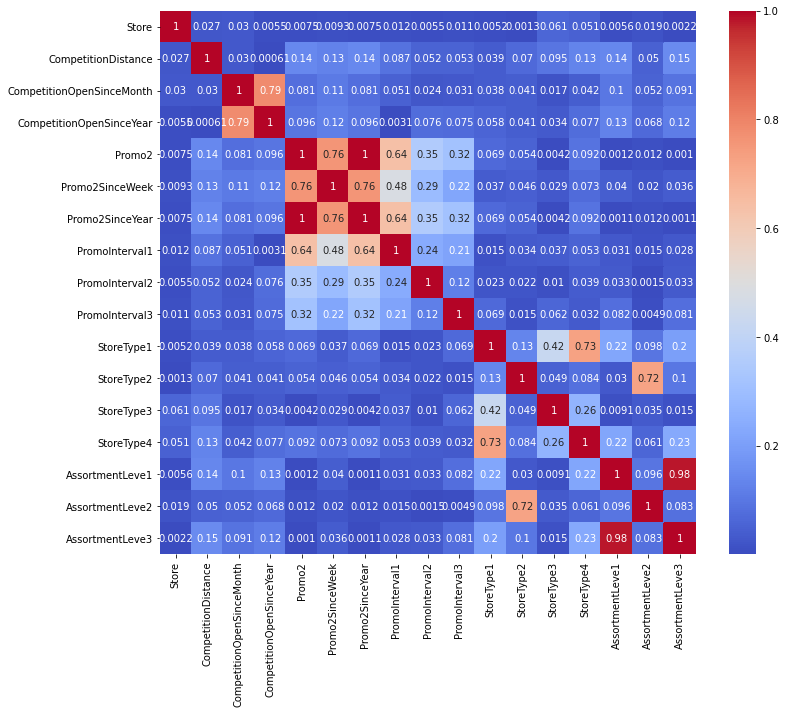

In [21]:
plt.figure(figsize=(12,10))
correlation = store_df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')

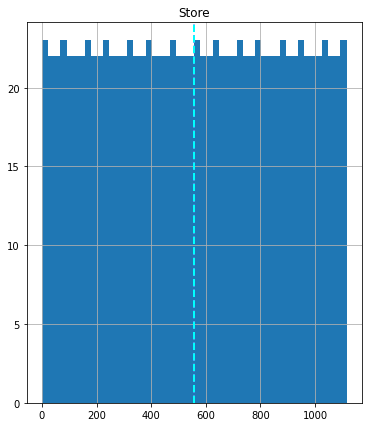

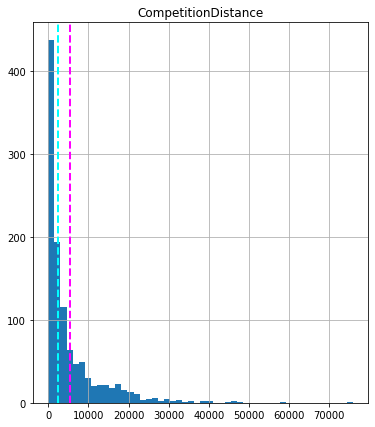

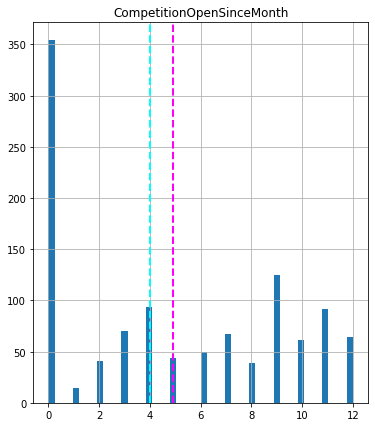

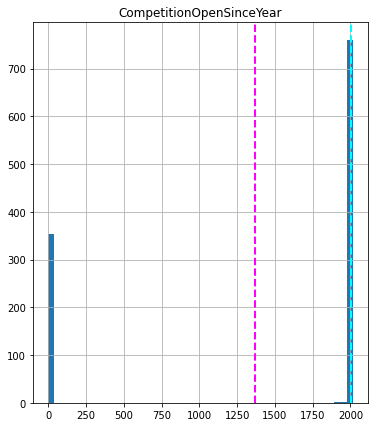

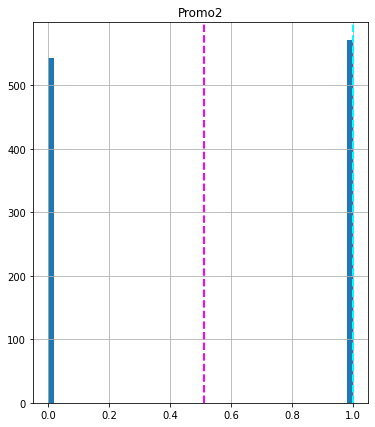

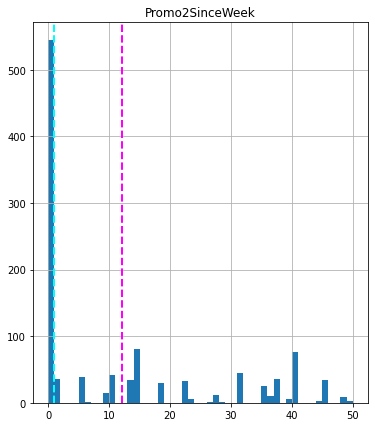

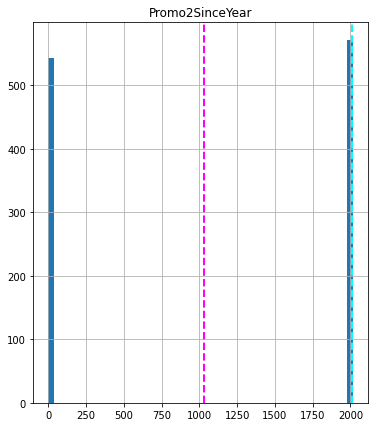

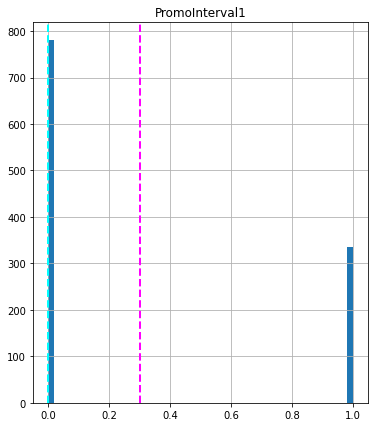

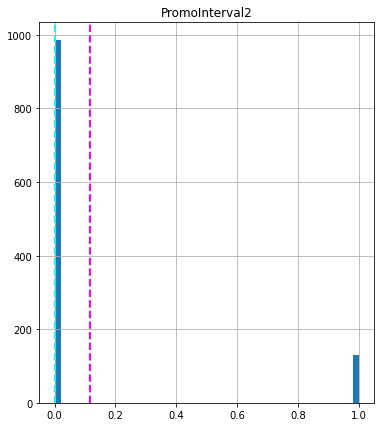

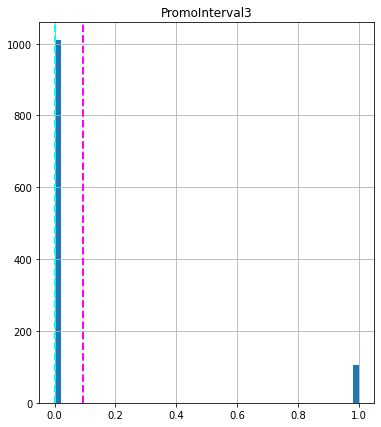

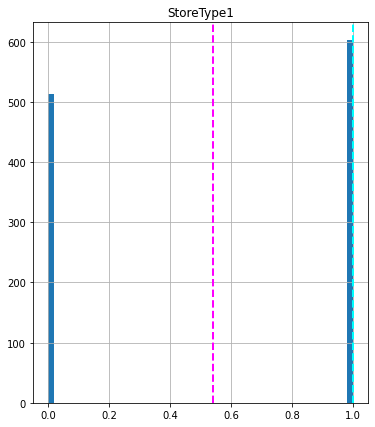

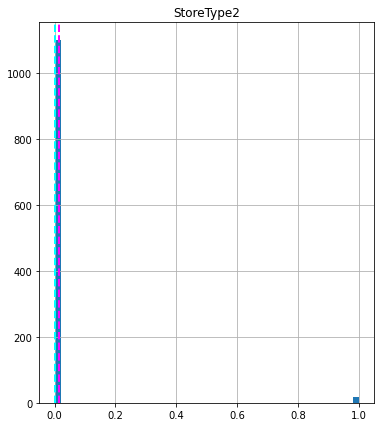

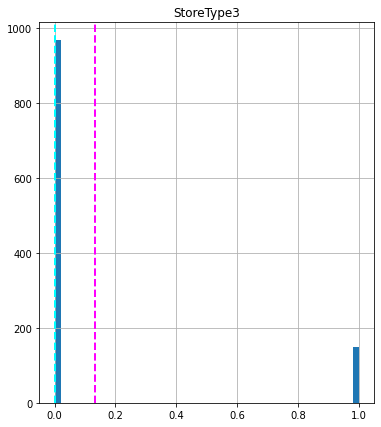

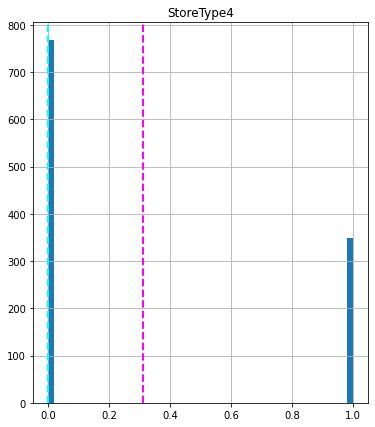

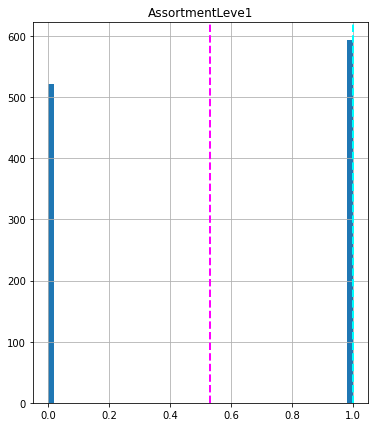

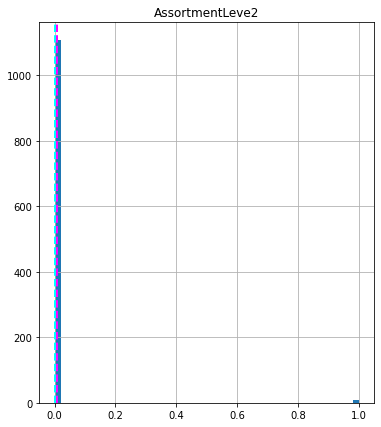

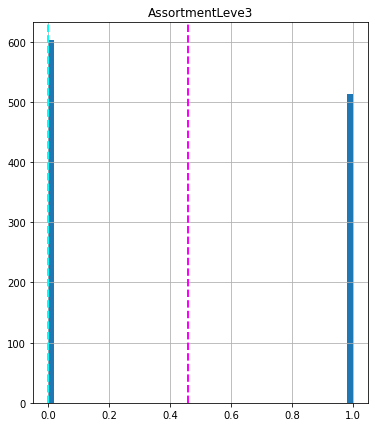

In [22]:
for col in store_df:
  figure=plt.figure(figsize=(6,7))
  ax=figure.gca()
  feature = store_df[col]
  feature.hist(bins=50, ax = ax)
  ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
  ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)    
  ax.set_title(col)
plt.show()

In [23]:
store_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [24]:
store_data_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [25]:
# changing date from string to integer value so wee can sort the data
def date_to_int(date):
  new_date = date[:4] + date[5:7] + date[8:]
  return int(new_date)
store_data_df['new_date'] = store_data_df['Date'].apply(lambda x: date_to_int(x))

In [26]:
store_data_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,new_date
0,1,5,2015-07-31,5263,555,1,1,0,1,20150731
1,2,5,2015-07-31,6064,625,1,1,0,1,20150731
2,3,5,2015-07-31,8314,821,1,1,0,1,20150731
3,4,5,2015-07-31,13995,1498,1,1,0,1,20150731
4,5,5,2015-07-31,4822,559,1,1,0,1,20150731


Text(0.5, 0, '')

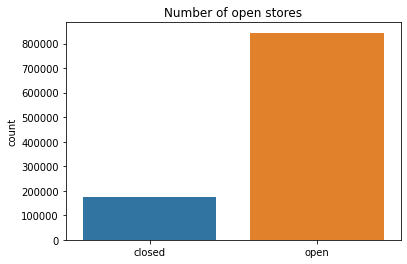

In [27]:
# number of stores open on a given day
count = sns.countplot(x=store_data_df['Open'])
count.set_title('Number of open stores')
count.set_xticklabels(['closed', 'open'])
count.set_xlabel('')

Text(0.5, 0, '')

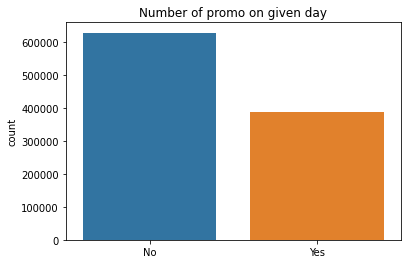

In [28]:
# number of promo 
count = sns.countplot(x=store_data_df['Promo'])
count.set_title('Number of promo on given day')
count.set_xticklabels(['No', 'Yes'])
count.set_xlabel('')

Text(0.5, 0, '')

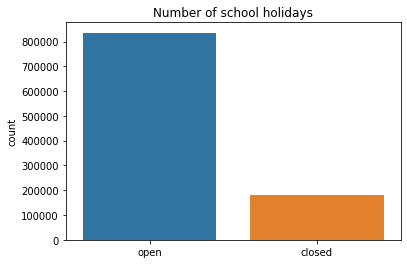

In [29]:
# number of school holiday
count = sns.countplot(x=store_data_df['SchoolHoliday'])
count.set_title('Number of school holidays')
count.set_xticklabels(['open', 'closed'])
count.set_xlabel('')

In [30]:
store_data_df['StateHoliday'].value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [31]:
# convert StateHoliday to features
# 1 indicates holiday and 0 indicates no holiday
store_data_df['public_holiday'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='a' else 0)
store_data_df['easter_holiday'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='b' else 0)
store_data_df['christmas'] = store_data_df['StateHoliday'].apply(lambda x: 1 if x=='c' else 0)

In [32]:
store_data_df['DayOfWeek'].value_counts()

5    145845
4    145845
3    145665
2    145664
7    144730
6    144730
1    144730
Name: DayOfWeek, dtype: int64

In [33]:
# convert day of week to binary features
store_data_df['DayOfWeek1'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==1 else 0)
store_data_df['DayOfWeek2'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==2 else 0)
store_data_df['DayOfWeek3'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==3 else 0)
store_data_df['DayOfWeek4'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==4 else 0)
store_data_df['DayOfWeek5'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==5 else 0)
store_data_df['DayOfWeek6'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==6 else 0)
store_data_df['DayOfWeek7'] = store_data_df['DayOfWeek'].apply(lambda x: 1 if x==7 else 0)

In [34]:
# drop columnns
store_data_df.drop(columns=['StateHoliday', 'Date', 'DayOfWeek'], inplace=True)

In [35]:
store_data_df['public_holiday'].value_counts()

0    996949
1     20260
Name: public_holiday, dtype: int64

In [36]:
store_data_df['easter_holiday'].value_counts()

0    1010519
1       6690
Name: easter_holiday, dtype: int64

In [37]:
store_data_df['christmas'].value_counts()

0    1013109
1       4100
Name: christmas, dtype: int64

Text(0.5, 1.0, 'Number of Holidays celebrated by stores')

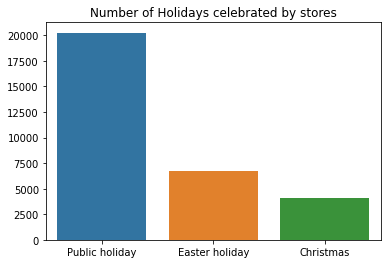

In [38]:
# plot number of holidays present in dataset
sns.barplot(x=['Public holiday','Easter holiday','Christmas'],
            y=[store_data_df['public_holiday'].value_counts()[1],store_data_df['easter_holiday'].value_counts()[1],store_data_df['christmas'].value_counts()[1]])
plt.title('Number of Holidays celebrated by stores')

In [39]:
store_data_df.head()

,Store,Sales,Customers,Open,Promo,SchoolHoliday,new_date,public_holiday,easter_holiday,christmas,DayOfWeek1,DayOfWeek2,DayOfWeek3,DayOfWeek4,DayOfWeek5,DayOfWeek6,DayOfWeek7
0,1,5263,555,1,1,1,20150731,0,0,0,0,0,0,0,1,0,0
1,2,6064,625,1,1,1,20150731,0,0,0,0,0,0,0,1,0,0
2,3,8314,821,1,1,1,20150731,0,0,0,0,0,0,0,1,0,0
3,4,13995,1498,1,1,1,20150731,0,0,0,0,0,0,0,1,0,0
4,5,4822,559,1,1,1,20150731,0,0,0,0,0,0,0,1,0,0


In [40]:
# checking senity of data
store_open_df = store_data_df.groupby(['Open']).sum()
store_open_df

,Store,Sales,Customers,Promo,SchoolHoliday,new_date,public_holiday,easter_holiday,christmas,DayOfWeek1,DayOfWeek2,DayOfWeek3,DayOfWeek4,DayOfWeek5,DayOfWeek6,DayOfWeek7
Open,,,,,,,,,,,,,,,,
0,96511898,0,0,11184,18264,3480351279995,19566,6545,4029,7170,1703,3729,11201,7205,672,141137
1,471527846,5873180623,644041755,376896,163457,17005142750924,694,145,71,137560,143961,141936,134644,138640,144058,3593


In [41]:
# calculate number of sstores open on holidays
store_holiday_df = store_open_df[['SchoolHoliday', 'public_holiday', 'easter_holiday', 'christmas']].reset_index()
store_holiday_df['Open'] = store_holiday_df['Open'].apply(lambda x: 'Open' if x==1 else 'Closed')
store_holiday_df

,Open,SchoolHoliday,public_holiday,easter_holiday,christmas
0,Closed,18264,19566,6545,4029
1,Open,163457,694,145,71


In [42]:
store_holiday_df= pd.melt(store_holiday_df, id_vars =['Open'])
store_holiday_df

,Open,variable,value
0,Closed,SchoolHoliday,18264
1,Open,SchoolHoliday,163457
2,Closed,public_holiday,19566
3,Open,public_holiday,694
4,Closed,easter_holiday,6545
5,Open,easter_holiday,145
6,Closed,christmas,4029
7,Open,christmas,71


Text(0.5, 1.0, 'Number of stores open on holidays')

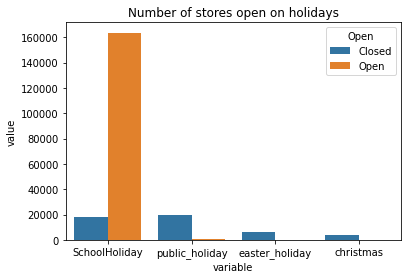

In [43]:
sns.barplot(x='variable',y='value',data=store_holiday_df,hue='Open')
plt.title('Number of stores open on holidays')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f41f5463b90>,
      dtype=object)

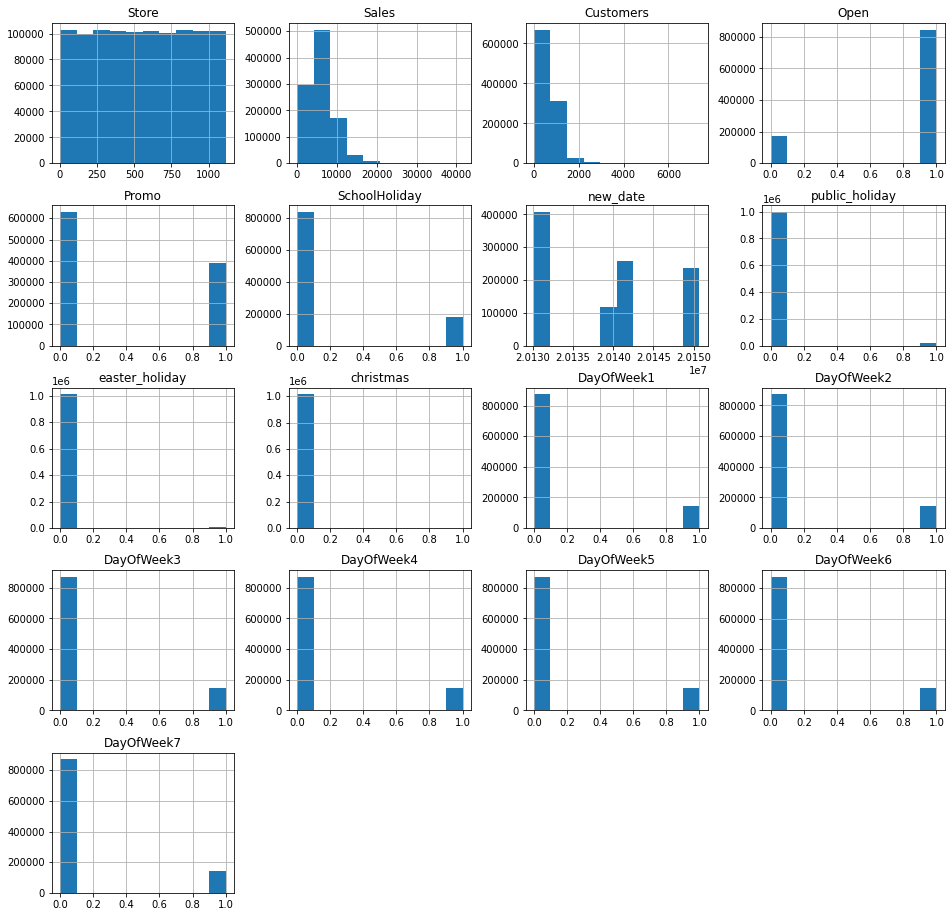

In [44]:
# plot the distribution of values
store_data_df.hist(figsize=(16,16))

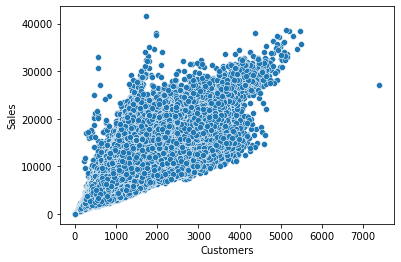

In [45]:
# plot relation between sales and customer
sns.scatterplot(data=store_data_df,x='Customers',y='Sales')

Text(0.5, 1.0, 'Correlation matrix')

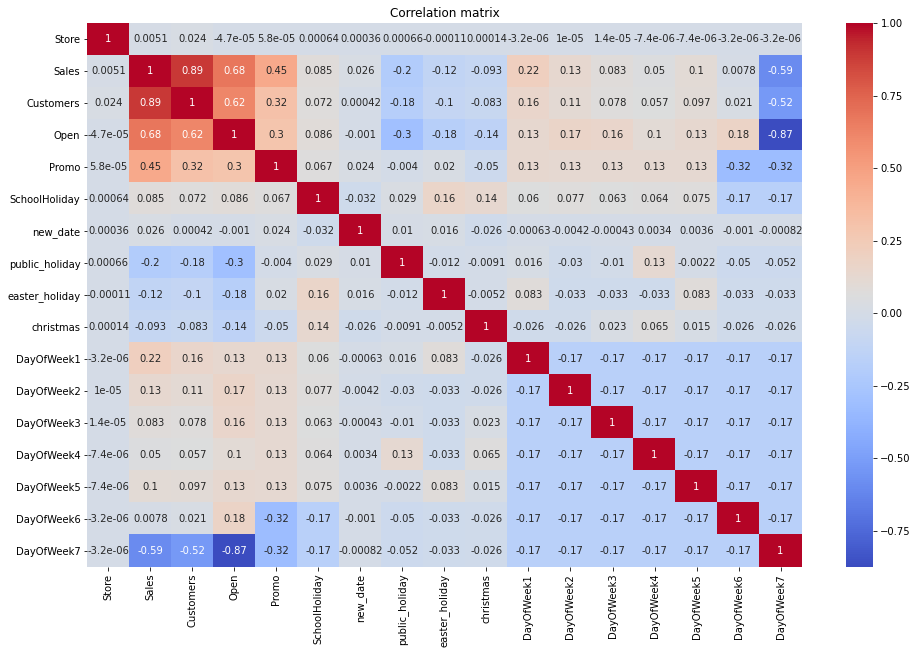

In [46]:
# plot correlation matrix
plt.figure(figsize=(16,10))
sns.heatmap(store_data_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation matrix')

In [47]:
# merge datasets
sales_df = pd.merge(left=store_data_df, right=store_df, on='Store')
sales_df.head()

,Store,Sales,Customers,Open,Promo,SchoolHoliday,new_date,public_holiday,easter_holiday,christmas,DayOfWeek1,DayOfWeek2,DayOfWeek3,DayOfWeek4,DayOfWeek5,DayOfWeek6,DayOfWeek7,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval1,PromoInterval2,PromoInterval3,StoreType1,StoreType2,StoreType3,StoreType4,AssortmentLeve1,AssortmentLeve2,AssortmentLeve3
0,1,5263,555,1,1,1,20150731,0,0,0,0,0,0,0,1,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,0,1,0,1,0,0
1,1,5020,546,1,1,1,20150730,0,0,0,0,0,0,1,0,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,0,1,0,1,0,0
2,1,4782,523,1,1,1,20150729,0,0,0,0,0,1,0,0,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,0,1,0,1,0,0
3,1,5011,560,1,1,1,20150728,0,0,0,0,1,0,0,0,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,0,1,0,1,0,0
4,1,6102,612,1,1,1,20150727,0,0,0,1,0,0,0,0,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0,0,0,0,0,1,0,1,0,0


In [48]:
# updating promo2 for given date
def continuous_promotion(data):
  promo_month = False
  # promo2 is valid for stores that participate in continuous and consecutive promotion
  if data['Promo2'] == 1:
    # promotion should be running on current month
    current_month = int((data['new_date']//100)%100)
    if ((current_month % 3 == 1) and (data['PromoInterval1'] == 1)):
      promo_month = True
    if ((current_month % 3 == 2) and (data['PromoInterval2'] == 1)):
      promo_month = True
    if ((current_month % 3 == 0) and (data['PromoInterval3'] == 1)):
      promo_month = True
    # if current moth is promo month then promotion should start before current date
    if promo_month:
      if ((data['new_date']/10000) > data['Promo2SinceYear']):
        # promo2 start before current year
        return 1
      if ((data['new_date']/10000) == data['Promo2SinceYear']):
        # promo2 start on this year
        if (current_month > ((data['Promo2SinceWeek']//4)+1)):
          # promo2 start before current month
          return 1
  return 0

In [49]:
# combine features for promo2
sales_df['Promo_cont'] = sales_df.apply(continuous_promotion, axis=1)

In [50]:
# remove columns
sales_df.drop(columns=['Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3'], inplace=True)

In [51]:
sales_df.head()

,Store,Sales,Customers,Open,Promo,SchoolHoliday,new_date,public_holiday,easter_holiday,christmas,DayOfWeek1,DayOfWeek2,DayOfWeek3,DayOfWeek4,DayOfWeek5,DayOfWeek6,DayOfWeek7,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,StoreType1,StoreType2,StoreType3,StoreType4,AssortmentLeve1,AssortmentLeve2,AssortmentLeve3,Promo_cont
0,1,5263,555,1,1,1,20150731,0,0,0,0,0,0,0,1,0,0,1270.0,9.0,2008.0,0,0,1,0,1,0,0,0
1,1,5020,546,1,1,1,20150730,0,0,0,0,0,0,1,0,0,0,1270.0,9.0,2008.0,0,0,1,0,1,0,0,0
2,1,4782,523,1,1,1,20150729,0,0,0,0,0,1,0,0,0,0,1270.0,9.0,2008.0,0,0,1,0,1,0,0,0
3,1,5011,560,1,1,1,20150728,0,0,0,0,1,0,0,0,0,0,1270.0,9.0,2008.0,0,0,1,0,1,0,0,0
4,1,6102,612,1,1,1,20150727,0,0,0,1,0,0,0,0,0,0,1270.0,9.0,2008.0,0,0,1,0,1,0,0,0


In [52]:
# removing the collinearity by converting to quantitative data of CompetitionOpenSinceYear and CompetitionOpenSinceMonth
def ApproxCompitionOpenSinceNumberOfDays(row):
  compitition_start_date= (row['CompetitionOpenSinceYear']*10000)+(row['CompetitionOpenSinceMonth']*100)+ 1 # add 1 as start of month
  competetion_time= row['new_date'] - compitition_start_date
  # check if competition exist
  if (row['CompetitionOpenSinceYear'] == 0) or (competetion_time <= 0):
    return 0
  # calculate compettition time in number of days
  days= competetion_time % 100
  months= (competetion_time//100) % 100
  years= competetion_time//10000
  if months>12:
    months = (months + 12)%100
  total_time= years*365 + months*30 + days
  return total_time

In [53]:
sales_df['CompitionOpenSinceNumberOfDays']=sales_df.apply(ApproxCompitionOpenSinceNumberOfDays,axis=1)

In [54]:
sales_df.drop(columns=['CompetitionOpenSinceYear','CompetitionOpenSinceMonth'],inplace=True)

In [55]:
sales_df.head()

,Store,Sales,Customers,Open,Promo,SchoolHoliday,new_date,public_holiday,easter_holiday,christmas,DayOfWeek1,DayOfWeek2,DayOfWeek3,DayOfWeek4,DayOfWeek5,DayOfWeek6,DayOfWeek7,CompetitionDistance,StoreType1,StoreType2,StoreType3,StoreType4,AssortmentLeve1,AssortmentLeve2,AssortmentLeve3,Promo_cont,CompitionOpenSinceNumberOfDays
0,1,5263,555,1,1,1,20150731,0,0,0,0,0,0,0,1,0,0,1270.0,0,0,1,0,1,0,0,0,2520.0
1,1,5020,546,1,1,1,20150730,0,0,0,0,0,0,1,0,0,0,1270.0,0,0,1,0,1,0,0,0,2519.0
2,1,4782,523,1,1,1,20150729,0,0,0,0,0,1,0,0,0,0,1270.0,0,0,1,0,1,0,0,0,2518.0
3,1,5011,560,1,1,1,20150728,0,0,0,0,1,0,0,0,0,0,1270.0,0,0,1,0,1,0,0,0,2517.0
4,1,6102,612,1,1,1,20150727,0,0,0,1,0,0,0,0,0,0,1270.0,0,0,1,0,1,0,0,0,2516.0


Text(0.5, 1.0, 'Correlation matrix')

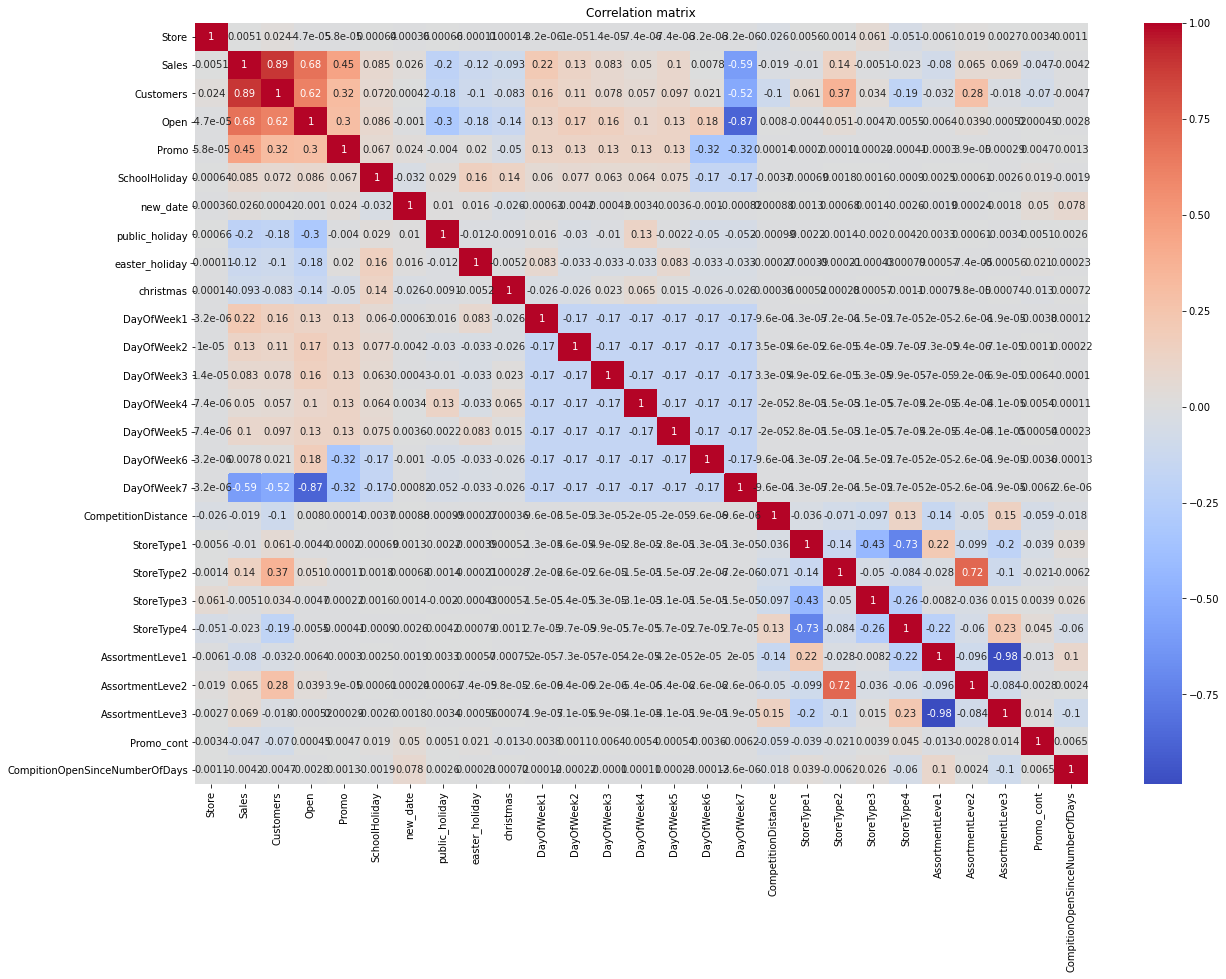

In [56]:
# plot correlation matrix
plt.figure(figsize=(20,14))
sns.heatmap(sales_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation matrix')

#2. Model Building

In [57]:
# Importing the libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


split the data by date to test the model predictions

In [58]:
# split the dataset in 2 by dates, for test on last 6 weeks
highest_date = sales_df['new_date'].max()
highest_date

20150731

In [59]:
# removing 6 weeks from 2015-07-31
split_date = 20150515
train_data = sales_df[sales_df['new_date'] < split_date]
test_data = sales_df[sales_df['new_date'] >= split_date]
print(train_data.shape, test_data.shape)

(930239, 27) (86970, 27)


In [60]:
dependent_variable = 'Sales'

In [61]:
# Create a list of independent variables
independent_variables = list(set(sales_df.columns.tolist()) - {dependent_variable})

In [62]:
independent_variables

['StoreType3',
 'StoreType1',
 'DayOfWeek3',
 'easter_holiday',
 'new_date',
 'AssortmentLeve2',
 'DayOfWeek4',
 'AssortmentLeve1',
 'Open',
 'Promo',
 'CompetitionDistance',
 'Customers',
 'DayOfWeek7',
 'Promo_cont',
 'christmas',
 'public_holiday',
 'SchoolHoliday',
 'DayOfWeek1',
 'StoreType4',
 'AssortmentLeve3',
 'Store',
 'DayOfWeek5',
 'CompitionOpenSinceNumberOfDays',
 'DayOfWeek2',
 'StoreType2',
 'DayOfWeek6']

In [63]:
X_train = train_data[independent_variables].values
X_test = test_data[independent_variables].values
y_train = train_data[dependent_variable].values
y_test = test_data[dependent_variable].values

In [64]:
# Transforming data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [65]:
X_train[0:10]

array([[1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.01674137, 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.05801748, 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 1.        , 0.        , 0.99995101,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.01674137, 0.07079047, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.05799373, 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.99990202,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.01674137, 0.05928533, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
      

## Building linear regression model

In [66]:
# Fitting Multiple Linear Regression to the Training set
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [67]:
regressor.intercept_

-1156544419870694.0

In [68]:
regressor.coef_

array([ 4.67493032e+14,  4.67493032e+14,  1.89577803e+15, -7.05018738e+02,
        1.80534368e+02, -1.20672664e+15,  1.89577803e+15, -1.20672664e+15,
        1.19122386e+03,  1.24906309e+03,  1.39055593e+03,  5.30561826e+04,
        1.89577803e+15,  7.56049983e+01,  3.71252513e+02, -1.62445835e+02,
        1.35655338e+02,  1.89577803e+15,  4.67493032e+14, -1.20672664e+15,
       -8.90312500e+01,  1.89577803e+15,  7.22446289e+02,  1.89577803e+15,
        4.67493032e+14,  1.89577803e+15])

In [69]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)

**Model Evaluation**

In [70]:
# Function to check for Evaluation Metrics
def mean_absolute_percentage_error(actual, pred):
  error_term = actual - pred
  num_of_observation = len(error_term)
  sum = 0
  for i in range(num_of_observation):
    if actual[i] != 0:
      sum = sum + abs(error_term[i]/actual[i])
    else:
      sum = sum + abs(error_term[i])
  return sum*100/num_of_observation

def evaluation_metrics(actual, pred, num_of_features=0):
  MSE = mean_squared_error (actual , pred)
  print('Mean Squared Error :' , round(MSE,2))
  print('Root Mean Squared Error :' , round(np.sqrt(MSE)))
  error_term = actual - pred
  num_of_observation = len(error_term)
  MAE = sum(abs(error_term))/num_of_observation
  print('Mean Absolute Error :' , round(MAE,2))
  print('Mean Absolute Percentage Error :' , round(mean_absolute_percentage_error(actual, pred),2), '%')
  R2 = r2_score(y_test , y_pred)
  print('R-Square :' , round(R2,2)) 
  if num_of_features > 0:
    adj_r2 = 1-(1-R2)*((num_of_observation-1)/(num_of_observation-num_of_features-1))
    print("Adjusted R-Square : ", round(adj_r2, 2))

In [71]:
# Evaluating Linear Reegression model
evaluation_metrics(y_test , y_pred, len(independent_variables))

Mean Squared Error : 1599762.26
Root Mean Squared Error : 1265
Mean Absolute Error : 892.85
Mean Absolute Percentage Error : 7306.41 %
R-Square : 0.89
Adjusted R-Square :  0.89


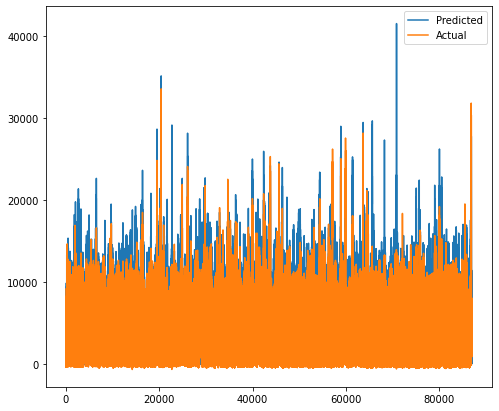

In [72]:
#Plot between actual and predicted
plt.figure(figsize=(8,7))
plt.plot(y_test)
plt.plot(y_pred)
plt.legend(["Predicted" , "Actual"])
plt.show()

**Checking the assumptions of Linear Regression**

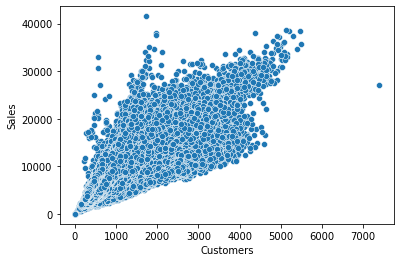

In [73]:
# Plotting the relationship between sales and customer
sns.scatterplot(data=sales_df,x='Customers',y='Sales')

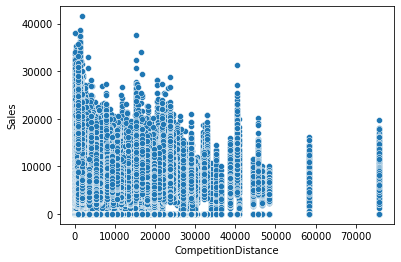

In [74]:
# Plotting the relationship between Sales and Competition Distance
sns.scatterplot(data=sales_df,x='CompetitionDistance',y='Sales')

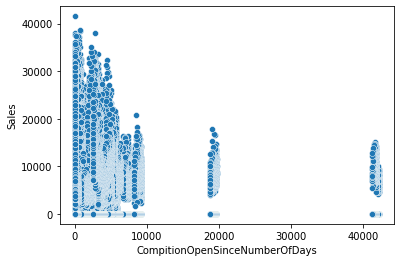

In [75]:
# Plotting the relationship between Sales and Compition Open Since Number Of Days
sns.scatterplot(data=sales_df,x='CompitionOpenSinceNumberOfDays',y='Sales')

In [76]:
# Checking the mean of Residuals
sum(y_pred-y_test)/ len(sales_df)

-11.347289495079183

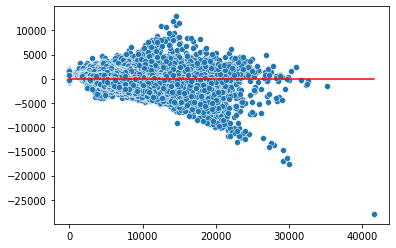

In [77]:
# Checking Homoscedasticity
error_terms = y_pred-y_test
plot = sns.scatterplot(x=y_test,y=error_terms)
# plot.map_dataframe(plot_hline,y=0)
plt.plot([0,max(y_test)], [0,0], 'r-')

**Removing Multicollinearity**

**Regularization**

**Implementing Lasso Regression**

In [78]:
lasso = Lasso(alpha = 0.1 , max_iter = 1000)
lasso.fit(X_train , y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [79]:
lasso.score(X_train , y_train)

0.9029126394246817

In [80]:
y_pred_lasso = lasso.predict(X_test)

In [81]:
#Evaluation metrics for Lasso Regression
evaluation_metrics(y_test , y_pred_lasso, len(independent_variables))

Mean Squared Error : 1600696.1
Root Mean Squared Error : 1265
Mean Absolute Error : 892.77
Mean Absolute Percentage Error : 7273.31 %
R-Square : 0.89
Adjusted R-Square :  0.89


**Running Grid Search Cross Validation for Lasso Regression**

In [ ]:
#cross validation
lasso = Lasso()
parameters = {'alpha': [1e-5,1e-3,1e-1,1]}
lasso_regressor = GridSearchCV(lasso , parameters , scoring='neg_mean_squared_error' , cv=5)
lasso_regressor.fit(X_train, y_train)

In [ ]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

In [ ]:
y_pred_lasso = lasso_regressor.predict(X_test)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(y_pred_lasso)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

In [ ]:
#Evaluation metrics for Lasso Regression
evaluation_metrics(y_test , y_pred_lasso, X_test.shape[1])

**Implementing Ridge Regression**

In [95]:
from sklearn.linear_model import Ridge

ridge  = Ridge(alpha=0.1)

In [96]:
ridge.fit(X_train,y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [97]:
ridge.score(X_train, y_train)

0.9029140733968662

In [100]:
y_pred_ridge = ridge.predict(X_test)

In [101]:
#Evaluation metrics for Ridge Regression
evaluation_metrics(y_test , y_pred_ridge, len(independent_variables))

Mean Squared Error : 1600042.55
Root Mean Squared Error : 1265
Mean Absolute Error : 892.78
Mean Absolute Percentage Error : 7282.78 %
R-Square : 0.89
Adjusted R-Square :  0.89


**Running Grid Search Cross Validation for Lasso Regression**

In [102]:
#cross validation
ridge = Ridge()
parameters = {'alpha': [1e-5,1e-3,1e-1,1]}
ridge_regressor = GridSearchCV(ridge , parameters , scoring='neg_mean_squared_error' , cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.001, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [103]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1}

Using  {'alpha': 1}  the negative mean squared error is:  -1490679.0641362518


In [104]:
#Model Prediction
y_pred_ridge = ridge_regressor.predict(X_test)

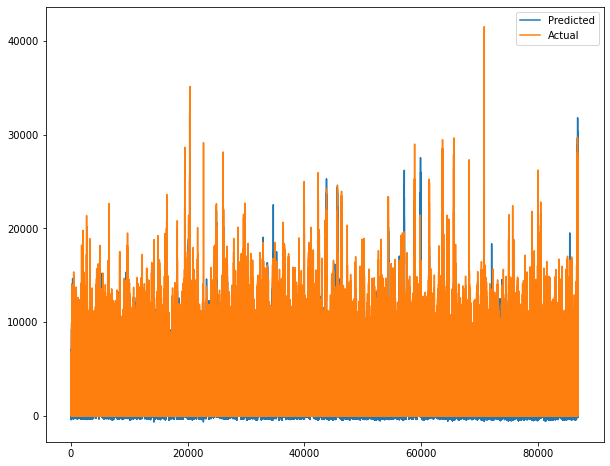

In [105]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_ridge)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()

**Implementing Elastic net Regression**

In [108]:
from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)

In [109]:
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [110]:
elasticnet.score(X_train, y_train)

0.5649362863427682

In [111]:
y_pred_en = elasticnet.predict(X_test)

In [112]:
#Evaluation metrics for Elastic Net Regression
evaluation_metrics(y_test , y_pred_en, len(independent_variables))

Mean Squared Error : 6271862.46
Root Mean Squared Error : 2504
Mean Absolute Error : 1738.29
Mean Absolute Percentage Error : 15113.11 %
R-Square : 0.89
Adjusted R-Square :  0.89


**Running Grid Search Cross Validation for Elastic Net Regression**

In [ ]:
#cross validation
elastic = ElasticNet()
parameters = {'alpha': [1e-5,1e-3,1e-1,1]}
elastic_regressor = GridSearchCV(elastic , parameters , scoring='neg_mean_squared_error' , cv=5)
elastic_regressor.fit(X_train, y_train)

In [ ]:
y_pred_en = elastic_regressor.predict(X_test)

In [ ]:
print("The best fit alpha value is found out to be :" ,elastic_regressor.best_params_)
print("\nUsing ",elastic_regressor.best_params_, " the negative mean squared error is: ", elastic_regressor.best_score_)

In [ ]:
#Model Prediction
y_pred_en = elastic_regressor.predict(X_test)

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(y_pred_en)
plt.plot(np.array(y_test))
plt.legend(["Predicted","Actual"])
plt.show()